In [1]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split

# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

files_name = ['Accidents0514.csv', 'Casualties0514.csv', 'Vehicles0514.csv' ]
files_path = './data/'
complete_pickle = f"{files_path}complete_pickled.pkl"

main_data_path = "../data/correct/"

files = [f'{files_path}{name}'for name in files_name]
files

['./data/Accidents0514.csv',
 './data/Casualties0514.csv',
 './data/Vehicles0514.csv']

# Preprocessing

In [ ]:
df_acc = pd.read_csv(files[0], index_col=0, dtype={'LSOA_of_Accident_Location': str})
df_cas = pd.read_csv(files[1], index_col=0).drop('Vehicle_Reference', axis=1)
df_veh = pd.read_csv(files[2], index_col=0).drop('Vehicle_Reference', axis=1)

In [ ]:
df = df_acc.join(df_cas, lsuffix='_Cas', how='inner').join(df_veh, lsuffix='_Veh', how='inner')

((4287593, 64), (1640597, 31), (2216720, 13), (3004425, 20))

Save the complete joined dataset not already preprocessed. 

In [6]:
df.to_csv(f'{files_path}complete.csv')
df.to_pickle(f'{files_path}complete_pickled.pkl')

Check columns with NaN values.

In [62]:
nan_values = df.isna().sum()
nan_values = nan_values[nan_values > 0].sort_values(ascending=False)
nan_values

LSOA_of_Accident_Location    282711
Time                            264
Location_Easting_OSGR           256
Location_Northing_OSGR          256
Longitude                       256
Latitude                        256
dtype: int64

In [33]:
f'{nan_values.shape[0]}/{df.shape[1]} columns have nan values'

'6/64 columns have nan values'

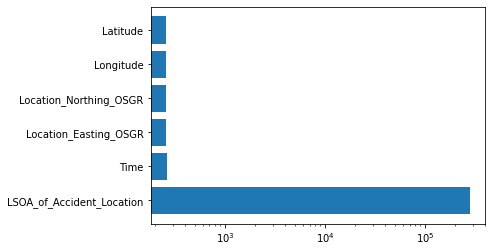

In [30]:
plt.barh(nan_values.index, nan_values, log=True)
plt.show()

Samples with missing latitude and longitude do not even have the Easting OSGR and Northing OSGR values.

In [46]:
# always 256
df[df['Latitude'].isna() & df['Longitude'].isna() & df['Location_Easting_OSGR'].isna() & df['Location_Northing_OSGR'].isna()]

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,...,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type
Accident_Index,,,,,,,,,,,,,,,,,,,,,
200504AL05063,NaN,NaN,NaN,NaN,4,2,2,2,09/09/2005,6,...,1,15,1,35,6,-1,-1,-1,8,3
200504AL05063,NaN,NaN,NaN,NaN,4,2,2,2,09/09/2005,6,...,1,15,2,71,10,-1,-1,-1,8,3
200504AL05063,NaN,NaN,NaN,NaN,4,2,2,2,09/09/2005,6,...,1,15,1,35,6,-1,-1,-1,8,3
200504AL05063,NaN,NaN,NaN,NaN,4,2,2,2,09/09/2005,6,...,1,15,2,71,10,-1,-1,-1,8,3
200504AL05082,NaN,NaN,NaN,NaN,4,3,2,1,08/10/2005,7,...,1,15,3,-1,-1,1998,2,2,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008950004890,NaN,NaN,NaN,NaN,95,3,2,3,06/05/2008,3,...,1,15,1,20,4,1242,1,10,-1,1
2008950004890,NaN,NaN,NaN,NaN,95,3,2,3,06/05/2008,3,...,1,15,1,37,7,1905,2,12,-1,1
2008950005704,NaN,NaN,NaN,NaN,95,3,2,1,09/05/2008,6,...,1,15,2,52,8,-1,-1,-1,-1,1


Map time value in HH:MM:SS format into total minutes. Fill missing values with the mean.

In [71]:
df['Time'] = df['Time'].map(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]) if type(x) == str else x)
df['Time'] = df['Time'].fillna(df['Time'].mean())

Map date in DD-MM-AAAA format into timestamp.

In [95]:
df['Date'] = df['Date'].map(lambda x: pd.to_datetime(x, infer_datetime_format=True ).timestamp())

Check the correlation between Latitude and Longitude coordinates and OSGR. Keep only OSGR coordinates and drop also the LSOA feature. 

In [5]:
df[['Latitude', 'Longitude', 'Location_Easting_OSGR', 'Location_Northing_OSGR']].corr()

,Latitude,Longitude,Location_Easting_OSGR,Location_Northing_OSGR
Latitude,1.000000,-0.403330,-0.393208,0.999972
Longitude,-0.403330,1.000000,0.999379,-0.401404
Location_Easting_OSGR,-0.393208,0.999379,1.000000,-0.391185
Location_Northing_OSGR,0.999972,-0.401404,-0.391185,1.000000


In [3]:
df = df.drop(['Latitude', 'Longitude', 'LSOA_of_Accident_Location'], axis=1)

Fill missing OSGR coordinates with the average values.

In [4]:
df['Location_Easting_OSGR'] = df['Location_Easting_OSGR'].fillna(df['Location_Easting_OSGR'].mean())
df['Location_Northing_OSGR'] = df['Location_Northing_OSGR'].fillna(df['Location_Northing_OSGR'].mean())

Transform Local Authoty categories into numerical values. 

In [11]:
df['Local_Authority_(Highway)'] = pd.factorize(df['Local_Authority_(Highway)'])[0]

Handle -1 missing values.

In [3]:
def replace_with_median_inplace(df, col, to_replace=-1):
    median = df[df[col] != to_replace][col].median()
    df[col] = df[col].replace(to_replace, median)


<BarContainer object of 41 artists>

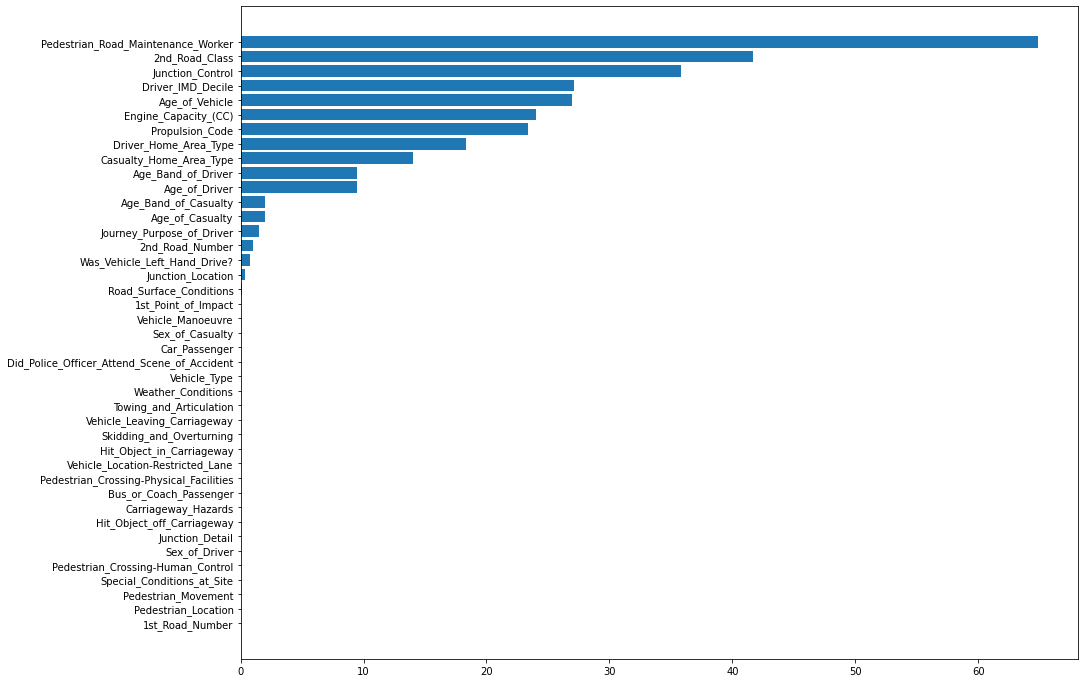

In [4]:
p = []

for col in df.columns:
    v_c = df[col].value_counts(normalize=True).get(-1.0, 0)
    if v_c != 0:
        p.append((col, v_c * 100))

p.sort(key= lambda el: el[1])

fig = plt.figure(figsize=(15, 12))
plt.barh([el[0] for el in p], [el[1] for el in p])

In [5]:
print(p)

[('1st_Road_Number', 4.6646218519341734e-05), ('Pedestrian_Location', 0.000349846638895063), ('Pedestrian_Movement', 0.00041981596667407567), ('Special_Conditions_at_Site', 0.0007463394963094678), ('Pedestrian_Crossing-Human_Control', 0.0009562474796465056), ('Sex_of_Driver', 0.00107286302594486), ('Junction_Detail', 0.001236124790762556), ('Hit_Object_off_Carriageway', 0.0014460327740995938), ('Carriageway_Hazards', 0.0016559407574366317), ('Bus_or_Coach_Passenger', 0.0017025869759559734), ('Pedestrian_Crossing-Physical_Facilities', 0.002169049161149391), ('Vehicle_Location-Restricted_Lane', 0.002285664707447745), ('Hit_Object_in_Carriageway', 0.002985357985237871), ('Skidding_and_Overturning', 0.003848313027845693), ('Vehicle_Leaving_Carriageway', 0.003848313027845693), ('Towing_and_Articulation', 0.005410961348243641), ('Weather_Conditions', 0.01049539916685189), ('Vehicle_Type', 0.012921002529857662), ('Did_Police_Officer_Attend_Scene_of_Accident', 0.01662937690214533), ('Car_Passe

### Driver_IMD_Decile

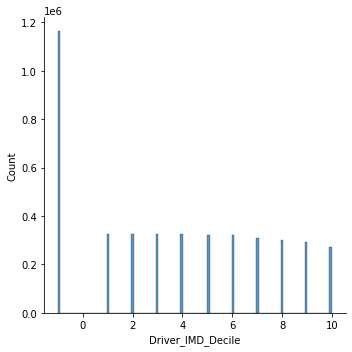

In [7]:
sns.displot(df['Driver_IMD_Decile'])

replace_with_median_inplace(df, 'Driver_IMD_Decile')

### Age_of_Vehicle

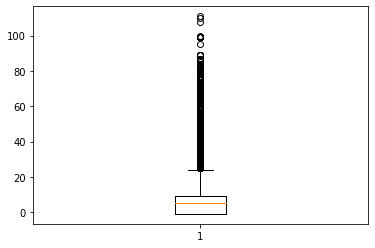

In [8]:
plt.boxplot(df['Age_of_Vehicle'])
plt.show()

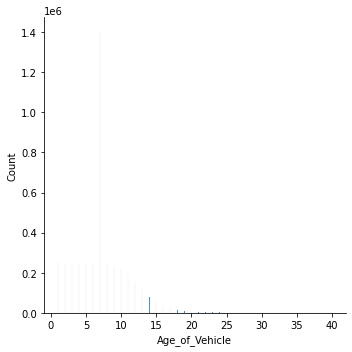

In [9]:
df['Age_of_Vehicle'] = df['Age_of_Vehicle'].clip(upper=40)

replace_with_median_inplace(df, 'Age_of_Vehicle')

sns.displot(df['Age_of_Vehicle'])

### Engine_Capacity_(CC)

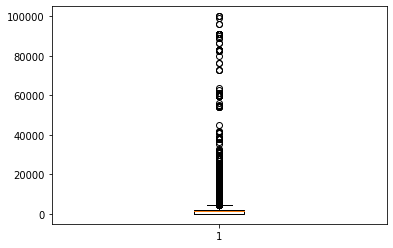

In [10]:
plt.boxplot(df["Engine_Capacity_(CC)"])
plt.show()

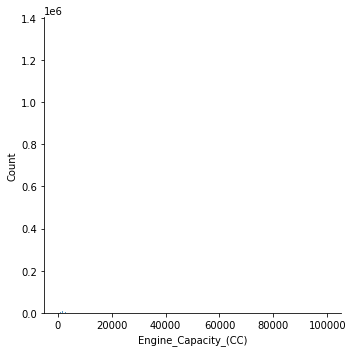

In [11]:
replace_with_median_inplace(df, 'Engine_Capacity_(CC)')

sns.displot(df['Engine_Capacity_(CC)'])

### Age of driver and casualty

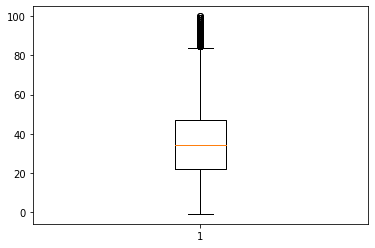

In [12]:
plt.boxplot(df['Age_of_Driver'])
plt.show()

In [13]:
replace_with_median_inplace(df, 'Age_of_Driver')
replace_with_median_inplace(df, 'Age_of_Casualty')

### Columns drop

In [15]:
columns_to_remove = ["Pedestrian_Road_Maintenance_Worker", "2nd_Road_Class", "2nd_Road_Number",
"Junction_Control", "Propulsion_Code", "Age_Band_of_Driver", "Age_Band_of_Casualty"]

df = df.drop(columns=columns_to_remove, axis=1)

<BarContainer object of 29 artists>

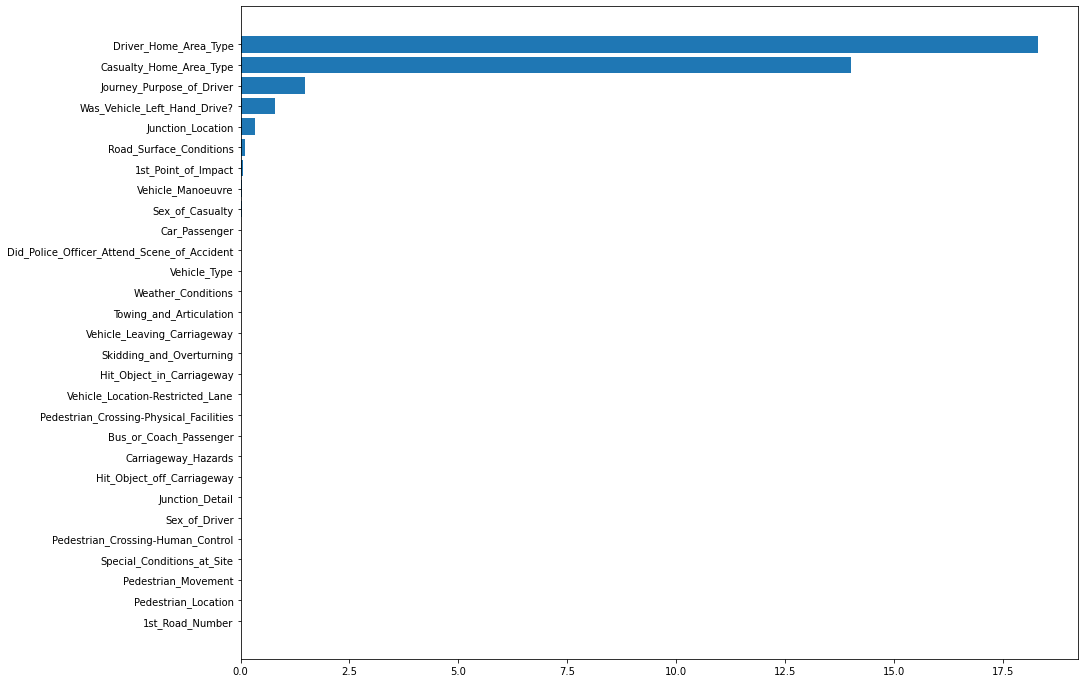

In [18]:
p2 = []

for col in df.columns:
    v_c = df[col].value_counts(normalize=True).get(-1.0, 0)
    if v_c != 0:
        p2.append((col, v_c * 100))

p2.sort(key= lambda el: el[1])

fig = plt.figure(figsize=(15, 12))
plt.barh([el[0] for el in p2], [el[1] for el in p2])

In [31]:
cols = list(df.columns)

cols.remove('Accident_Severity')
cols.append('Accident_Severity')

df = df[cols]

In [33]:
df.to_csv(f'{files_path}preprocessed.csv')
df.to_pickle(f'{files_path}preprocessed_pickled.pkl')

# Decision Tree

In [2]:
df = pd.read_pickle(f'{files_path}preprocessed_pickled.pkl')

In [4]:
x, y = df.drop('Accident_Severity', axis=1),  df['Accident_Severity']

In [3]:
df['Accident_Severity'].value_counts()

3    3607415
2     596571
1      83607
Name: Accident_Severity, dtype: int64

In [4]:
featsFormat = [
        "Continuous", "Continuous", "Categorical",
        "Continuous", "Continuous", "Continuous",
        "Continuous","Continuous", "Categorical",
        "Categorical", "Categorical", "Continuous",
        "Categorical", "Continuous", "Categorical",
        "Continuous", "Categorical", "Continuous",
        "Continuous", "Categorical", "Categorical",
        "Categorical", "Categorical", "Categorical",
        "Categorical", "Categorical", "Continuous",
        "Continuous", "Categorical", "Categorical",
        "Categorical", "Categorical", "Categorical",
        "Categorical", "Categorical", "Categorical",
        "Categorical", "Categorical", "Categorical",
        "Categorical", "Categorical", "Categorical",
        "Categorical", "Categorical", "Categorical",
        "Categorical", "Categorical", "Continuous",
        "Continuous", "Continuous", "Continuous",
        "Categorical"]

feat_name_format = list(zip(list(df.drop(columns="Accident_Severity").columns), featsFormat))

In [5]:
cat_cols_labels = [coltype[0] for coltype in list(feat_name_format) if coltype[1] == "Categorical"]

In [6]:
import math

def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

In [7]:
from sklearn.utils import resample

for dim in [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152]:
    print(f"===== {dim} ===== ")

    train_size = int(round_half_up(dim * 0.8))
    test_size = int(round_half_up(dim * 0.2))

    temp_train = resample(df, replace=False, n_samples=train_size, stratify=df["Accident_Severity"], random_state=42)
    print("Train dataset done")

    df_no_train = df.drop(temp_train.index, axis=0) # dataset - samples on train

    for col in cat_cols_labels:
        # print(f"Category {col}:")
        # print(f"\ton train: {len(temp_train[col].unique())} unique values")
        # now remove from df_no_train samples with different values
        # print(f"\ton the remainig dataset({df_no_train.shape[0]} samples): {len(df_no_train[col].unique())} unique values")
        df_no_train = df_no_train.loc[df_no_train[col].isin(temp_train[col].unique())] # only get values that are in 
        # print(f"\t\tafter the drop ({df_no_train.shape[0]} samples): {len(df_no_train[col].unique())} unique values")

    temp_test = df_no_train.sample(n=test_size, random_state=42)
    print("Test dataset done")

    t = [len([el for el in list(temp_test[cat].value_counts().index) if el not in list(temp_train[cat].value_counts().index)]) for cat in cat_cols_labels]
    consistency = all([el == 0 for el in t])
    
    print(f"Category consistency train/test: {consistency}")

    if consistency:
        temp_train.to_pickle(f'{main_data_path}input_train_{dim}.pkl')
        temp_test.to_pickle(f'{main_data_path}input_test_{dim}.pkl')

        temp_train.to_csv(f'{main_data_path}input_train_{dim}.csv')
        temp_test.to_csv(f'{main_data_path}input_test_{dim}.csv')
    else:
        print("DS not saved due to inconsistency")

===== 1024 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 2048 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 4096 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 8192 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 16384 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 32768 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 65536 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 131072 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 262144 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 524288 ===== 
Train dataset done
Test dataset done
Category consistency train/test: True
===== 1048576 ===== 
Train dataset done
Test dataset done
Cat

In [11]:
# check there arent same indexes
d1 = pd.read_csv(f'{main_data_path}input_train_8192.csv', index_col=0)
d2 = pd.read_csv(f'{main_data_path}input_test_8192.csv', index_col=0)

In [14]:
for cat in cat_cols_labels:
    print(cat)
    
    e1 = d1[cat].unique()
    e1.sort()

    e2 = d2[cat].unique()
    e2.sort()

    print(e1)
    print(e2)   
    

Police_Force
[ 1  3  4  5  6  7 10 11 12 13 14 16 17 20 21 22 23 30 31 32 33 34 35 36
 37 40 41 42 43 44 45 46 47 48 50 52 53 54 55 60 61 62 63 91 92 93 94 95
 96 97 98]
[ 1  3  4  5  6  7 10 11 12 13 14 16 17 20 21 22 23 30 31 32 33 34 35 36
 37 40 41 42 43 44 45 46 47 50 52 53 54 55 60 61 62 63 91 92 93 94 95 96
 97 98]
Local_Authority_(District)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  38  40  57
  60  61  62  63  64  65  70  71  72  73  74  75  76  77  79  80  82  83
  84  85  90  91  92  93  95 100 101 102 104 106 107 109 110 112 114 120
 121 122 123 124 126 127 128 129 130 139 140 141 142 143 144 145 146 147
 148 149 150 160 161 162 163 164 165 168 169 180 181 182 184 185 186 187
 189 200 202 203 204 206 210 211 213 215 228 231 232 233 240 241 243 245
 250 251 252 253 254 255 256 257 258 270 273 274 276 277 278 279 280 281
 282 283 284 285 286 290 291 292 293 294 300 302 303 305 306 307 

In [5]:
# import numpy as np

# # power of two
# for dim in [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152]:
#     temp_train, temp_test = train_test_split(df.sample(n=dim, random_state=42), test_size = 0.2)
#     print(temp_train['Accident_Severity'].value_counts())

#     temp_train.to_pickle(f'{main_data_path}input_train_{dim}.pkl')
#     temp_test.to_pickle(f'{main_data_path}input_test_{dim}.pkl')

3    692
2    109
1     18
Name: Accident_Severity, dtype: int64
3    1381
2     224
1      33
Name: Accident_Severity, dtype: int64
3    2770
2     452
1      54
Name: Accident_Severity, dtype: int64
3    5545
2     885
1     123
Name: Accident_Severity, dtype: int64
3    11073
2     1783
1      251
Name: Accident_Severity, dtype: int64
3    22154
2     3563
1      497
Name: Accident_Severity, dtype: int64
3    44123
2     7281
1     1024
Name: Accident_Severity, dtype: int64
3    88387
2    14490
1     1980
Name: Accident_Severity, dtype: int64
3    176508
2     29159
1      4048
Name: Accident_Severity, dtype: int64
3    352672
2     58505
1      8253
Name: Accident_Severity, dtype: int64
3    705289
2    116995
1     16576
Name: Accident_Severity, dtype: int64
3    1411257
2     233619
1      32845
Name: Accident_Severity, dtype: int64


## Decision Tree

In [18]:
dt = DecisionTreeClassifier()

r = dt.fit(x.iloc[:3_000_000, :], y.iloc[:3_000_000])

In [ ]:
r.score(x.iloc[:3_000_000 , :], y.iloc[:3_000_000])

In [ ]:
r.score(x.iloc[3_000_000: , :], y.iloc[3_000_000:])